# Hyperspectral Aerial Image Classification using Machine Learning

### Description:
Classification of Hyperspectral images (HSI) obtained from aerial sensors to estimate the land cover usage pattern using Machine Learning (ML).

### Value
The exercise of using classifying the land per the crop type using HSI, will enable us to understand the growing pattern, land usage, soil con-ditions, water access, human activity mapping and others,are  important  steps  in  the  goal  to  meet  the  challengesin  anticipated  food  production

### Data
Hyperspectral Imagery (HSI) refers to hundreds or even thousands of such bands captured in much narrower (10-20 nm) bands, offering very rich spectral information. Each such image is, in reality, a three-dimensional (3-D) volume with each voxel (3-D pixel) having both position information in the X and Y coordinates, and the spectral information content embedded in the Z direction

Data Source: http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes


### Author:
Praveen Pankajakshan

### Author Email address:
praveen.pankaj@ieee.org

### Dated:
June 12, 2020, 11:47PM

Last Modified: June 16, 2020 12:20PM

In [1]:
!pip install thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

Processing ./thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl


In [25]:
!pip install catboost

     |████████████████████████████████| 64.8MB 46kB/s 


##1. Import the necessary libraries

In [0]:
import sys 
from time import time

import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import ndimage
import math 
from thundersvm import SVC
#from sklearn.svm import SVC #if using sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Read the HSI data and ground truth as scipy array and store as numpy array or as a dataframe
Using the scipy io library

In [3]:
# Read the raw input data
rawdata = sio.loadmat("Indian_pines_corrected.mat")
I = rawdata['indian_pines_corrected']
print('Size of the input image is:', I.shape)
print(type(I))
nx, ny, nch = I.shape

# Store the input data before changing the values
Icopy = I.copy()

# Preprocessing and normalizing the data
I = I.astype(float)
I = I-np.min(I)
I = I/np.max(I)

# Read the Ground Truth
gtdata = sio.loadmat("Indian_pines_gt.mat")
G = gtdata['indian_pines_gt']
print('Size of the Ground Truth image is:', G.shape)
nclass = np.shape(np.unique(G))[0]

X = np.reshape(I, (nx*ny, nch))
Y = G.flatten()

Size of the input image is: (145, 145, 200)
<class 'numpy.ndarray'>
Size of the Ground Truth image is: (145, 145)


## 3. Drop the Background, and create training and test dataset

In [0]:
# Drop Background pixels
indxbg = np.where(Y==0)
indxnbg = np.where(Y!=0)
indices = range(np.shape( Y[indxnbg[0]] )[0])

ntest = 0.90
# Split into a training and testing set
enablepca = 0


if enablepca:
  # With using PCA
  # There can be drop in accuracy 
  ncomp = 25 #For indian pines dataset
  pca = PCA(n_components=ncomp)
  scaler = StandardScaler().fit(X)
  Xnorm = scaler.transform(X)

  Xpca = pca.fit_transform(Xnorm)
  X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
      Xpca[indxnbg[0], :], Y[indxnbg[0]], indxnbg[0], 
      test_size = ntest, 
      stratify = Y[indxnbg[0]], 
      random_state = 42)
else:
  # Without using PCA
  X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
      X[indxnbg[0], :], Y[indxnbg[0]], indxnbg[0],
      test_size = ntest, 
      stratify = Y[indxnbg[0]], 
      random_state = 42)

In [28]:
#import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
# Note that the parameters of C and gamma change if PCA is enabled
# without PCA, best C=35 and gamma=8
if enablepca:
  clf = SVC(C=79, gamma=0.01, kernel='rbf', 
          verbose=True, 
          class_weight='balanced', 
          probability=True)
else:
  #clf = CatBoostClassifier()
  clf = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=5,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    scale_pos_weight=1,
                    objective='multi:softprob',
                    num_class = 17,
                    seed=0, 
                    verbose=11)
  #clf = SVC(C=35, gamma=8, kernel='rbf', 
  #        verbose=True, 
  #        class_weight='balanced', 
  #        probability=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
ypredprob = clf.predict_proba(X_test)

score = [i for i in range(len(y_test)) if list(y_test)[i] == y_pred[i]]
print("Validation Score: %d out of: %d"%(len(score), len(y_test)))
accuracy = float(len(score))*100/len(y_test)
print("Validation Accuracy: %0.3f"%(accuracy))
# Direct script: print(clf.score(X_test, y_test))

ybg = np.zeros(np.shape(indxbg))
yhat = np.append(y_train, y_pred)
yhat = np.append(yhat, ybg)
indx = np.append(indices_train, indices_test)
indx = np.append(indx, indxbg)
yhat = yhat[np.argsort(indx)]

G_svm = np.reshape(yhat, np.shape(G), order='C')

yhatprob = pd.get_dummies(yhat)
yhatprob = yhatprob.values
G_svm_prob = np.zeros((nx, ny, nclass))
for i in range(nclass):
  G_svm_prob[:, :, i] = np.reshape(yhatprob[:, i], (nx, ny))

Validation Score: 6917 out of: 9225
Validation Accuracy: 74.981


In [0]:
def filtering(inpt, k, mode, cval):
    '''
    Filtering the input with the given filter k
    ---------
    input parameters
    ---------
    inpt : input image(3d probability map)
    k : Filter for convolution(2d) 
    
    returns
    ------
    result: Filtered output with given filter (shape = (nx, ny, n_class)) 
    '''
    
    result = ndimage.convolve(inpt, k, mode=mode, cval=cval)
    return result

def similarity(inpt, k, tau, mode, cval):
    '''
    Calculates the spatial nearness and spectral similarity measures
    ---------
    input parameters
    ---------
    inpt : input image (3D)
    k : kernel for convolution (2D)
    tau: smoothing parameter
    
    returns
    ------
    result: the similarity measure 
    '''

    result = (ndimage.convolve(inpt, k, mode=mode, cval=cval)**2).sum(axis = 2)
    result = np.exp(-result/2*tau**2)
    return result

def get_probability_map(cmap):
    '''
    One-Hot encode the classification map
    --------
    input parameters
    ----------
    cmap: 2d spectral classification map
    returns
    -------
    result: 3d binary classification map (onehot encoded) 
    '''
    n_class = len(np.unique(cmap))
    nx, ny = cmap.shape
    result = np.zeros((nx, ny, n_class))
    
    for i in range(n_class):
        result[:, :, i] = (cmap == i) 
    
    result[:, :, 0] = 0
    return result

def get_cordinate(img_shape):
    '''
    Get spatial coordinates
    ---------
    input parameters
    ---------
    img_shape : a tuple of image shape (nx, ny)
    return
    ------
    result: 3D matrix with coordinates
    '''
    nx, ny = img_shape
    result = np.meshgrid(np.arange(0, nx), np.arange(0, ny))
    return np.transpose(result)

def set_background(inpt, index):
    '''
    Set background pixel values to zero
    ----------
    input parameters
    ----------
    inpt: input array
    index: index of background pixel
    
    returns
    -------
    result: array with background removed
    '''
    nx, ny, nz = inpt.shape
    func = np.vectorize(lambda x: (int(x/ny), x % ny))
    x, y = func(index)
    for i, j in zip(x,y):
        inpt[i,j,:] = 0
    return inpt

In [0]:
def spatio_spectral_learning(X, cmap, nclass, back_index, r = 3, sigma = 3, tau = 1, beta = 0.5, mode='reflect', cval=0.0):
    '''
    Spatial Nearness and Spectral Similarity Trade-off
    ----------
    input parameters
    ----------
    X : 3-dimensional hyperpectral image
    cmap: Spectral Classification Map
    r : kernel size parameter (2r+1)x(2r+1)
    sigma: spectral smoothing parameter
    tau: spatial smoothing parameter
    beta: trade-off parameter
    mode : Padding method{‘reflect’,’constant’,’nearest’,’mirror’, ‘wrap’}, optional
           the mode parameter determines how the array borders are handled. 
           For ‘constant’ mode, values beyond borders are set to be cval. 
           Default is ‘reflect’.
    cval : Value to fill past edges of input if mode is ‘constant’. 
           Default is 0.0
    
    returns
    -------
    result : The result of convolution of input with weights.
    
    '''
    #storing params of the function for validation
    params = {'r': r, 'sigma': sigma, 'tau': tau, 'beta': beta, 'mode': mode, 'cval': cval}    
    #shape parameters
    nx, ny, n_feature = X.shape
    
    
    #create output ndarray
    result = np.zeros((nx, ny, nclass), dtype = 'float64')
    
    #kernel/filter related parameter
    kernel_side = 2*r + 1
    num_elem = kernel_side * kernel_side
    neigh_index = [i for i in range(num_elem) if i != np.floor(num_elem/2)]

    pmap = get_probability_map(cmap)
    #plt.imshow(np.argmax(pmap))

    #cordinate ndarray for spatial similarity
    cord_mat = np.array(get_cordinate((nx, ny)))
    
    t0 = time()
    for idx in neigh_index:
        #construct the respective filter of each iteration
        print(idx)
        t1 = time()
        #filter for every index( neighbourhood pixel = 1, refernce pixel = -1)
        k = np.zeros((kernel_side, kernel_side, 1)) ; 
        k[int(idx / kernel_side), idx % kernel_side,0] = 1
        k[r,r,0] = -1
        
        ##convolution with X and cord_mat to get spatial and spectral similarity
        #spectral similarity convolution
        spectral_sim = similarity(inpt = X, k = k, tau = sigma, mode = mode, cval = cval)
        #spatial similarity convolution
        spatial_sim = similarity(inpt= cord_mat, k= k, tau= tau, mode = mode, cval = cval)
        #probalilty map covolution
        #filter for this covolution is different fron previous(neighbourhood pixel = 1, refernce pixel = 0)
        k[r,r,0] = 0
        pmap_conv = filtering(inpt = pmap, k = k, mode = mode , cval = cval)
        
        #I_x_x convolution
        # input is a reward(1) and penalty(-1) ndarray; but filter is  
        #filter(neighbourhood pixel = 1, refernce pixel = 0)
        pmap[pmap == 0] = -1
        I_x_x_conv = filtering(inpt = pmap, k = k, mode = mode, cval = cval)
        
        #calculate final potentials
        #broadcast axis_2 of spatial similarity and spectral similarity to n_class to 
        #map pmap_conv and I_x_x dimension, i.e, (nx, ny, n_class)
        sum_similarity = spectral_sim + spatial_sim
        sum_similarity = np.repeat(sum_similarity[:,:,np.newaxis], nclass, axis = 2)
        
        potential = (1-beta)*sum_similarity*pmap_conv + beta*I_x_x_conv
        
        #sum potential of all neighbourhood pixels
        result += potential

        t2 = time()
        print('time per iteration: ', t2 - t1)
    t3 = time()   
    print('total time', t3-t0)
    print('average time per filter', (t3-t0)/(num_elem - 1))
    result = set_background(result, back_index)
    #plt.figure(dpi=300) 
    plt.imshow(spatial_sim, cmap= 'PRGn'); 
    plt.show()
    plt.imshow(spectral_sim); plt.colorbar(); 
    plt.axis('off');
    plt.savefig('spectralsimilarity_indianpines.eps', dpi=30)
    plt.show();
    return result.argmax(axis = 2), params

0
time per iteration:  0.12254929542541504
1
time per iteration:  0.1089944839477539
2
time per iteration:  0.10764789581298828
3
time per iteration:  0.11557292938232422
4
time per iteration:  0.10608744621276855
5
time per iteration:  0.1098470687866211
6
time per iteration:  0.11549162864685059
7
time per iteration:  0.11103343963623047
8
time per iteration:  0.10721707344055176
9
time per iteration:  0.1182253360748291
10
time per iteration:  0.1066596508026123
11
time per iteration:  0.10780954360961914
12
time per iteration:  0.1109771728515625
13
time per iteration:  0.11017417907714844
14
time per iteration:  0.10500168800354004
15
time per iteration:  0.10982322692871094
16
time per iteration:  0.10293841361999512
17
time per iteration:  0.10581684112548828
18
time per iteration:  0.11424708366394043
19
time per iteration:  0.10565876960754395
20
time per iteration:  0.10279202461242676
21
time per iteration:  0.11143016815185547
22
time per iteration:  0.10514235496520996
23


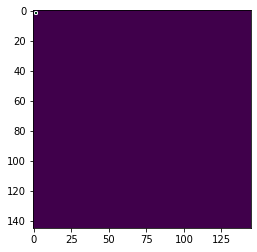

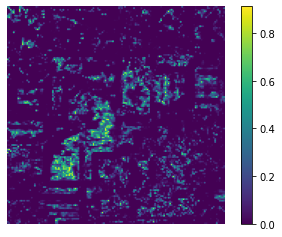

In [30]:
img, params = spatio_spectral_filter(X = I, cmap= G_svm, nclass=nclass , 
                              back_index= indxbg, 
                              r = 4, 
                              tau = 4.33, 
                              sigma = 9, 
                              beta = 0.5)

Text(0.5, 1.0, 'Trade-Off Classification Map')

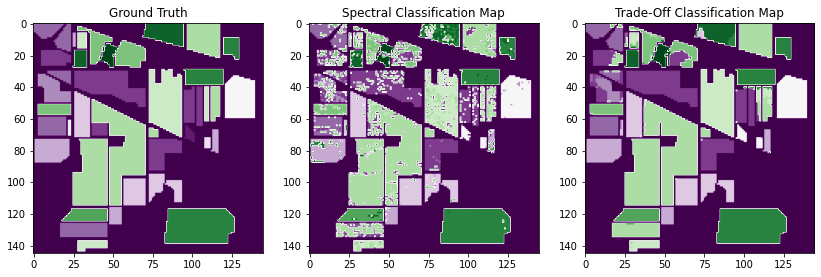

In [31]:
plt.figure(1, (14,10))
plt.subplot(1,3,1)
plt.imshow(G, cmap= 'PRGn')
plt.title('Ground Truth')

plt.subplot(1,3,2)
plt.imshow(G_svm, cmap= 'PRGn')
plt.title('Spectral Classification Map')

plt.subplot(1,3,3)
plt.imshow(img, cmap= 'PRGn')
plt.title('Trade-Off Classification Map')